# Comparison gps/argos, cutoff, drogue/undrogue
For gps+argos, drogued, <25km, <30min

In [1]:
import numpy as np
import pandas as pd
import xarray as xr

import dask.dataframe as dd
import os
from glob import glob

import matplotlib.pyplot as plt

import histlib.matchup as match
from  histlib.diagnosis import build_matchup_dataframe, synthetic_figure, path_csv, put_fig_letter
from histlib.cstes import labels, zarr_dir, matchup_dir, c0
plt.rcParams["axes.edgecolor"] = "w"

/home1/datahome/mdemol/.miniconda3/envs/histenv2/lib/python3.9/site-packages/dask/config.py:742: FutureWarning: Dask configuration key 'distributed.scheduler.transition-log-length' has been deprecated; please use 'distributed.admin.low-level-log-length' instead
  warnings.warn(
/home1/datahome/mdemol/.miniconda3/envs/histenv2/lib/python3.9/site-packages/dask/config.py:742: FutureWarning: Dask configuration key 'distributed.comm.recent-messages-log-length' has been deprecated; please use 'distributed.admin.low-level-log-length' instead
  warnings.warn(


In [2]:
if True:
    from dask.distributed import Client
    from dask_jobqueue import PBSCluster
    #cluster = PBSCluster(cores=56, processes=28, walltime='04:00:00')
    #cluster = PBSCluster(cores=7, processes=7, walltime='04:00:00')
    cluster = PBSCluster(cores=10, processes=10, walltime='00:30:00')
    w = cluster.scale(jobs=1)
else:
    from dask.distributed import Client, LocalCluster
    cluster = LocalCluster()

client = Client(cluster)
client

Connection method: Cluster object,Cluster type: dask_jobqueue.PBSCluster
Dashboard: http://10.148.0.145:8787/status,
Dashboard: http://10.148.0.145:8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.148.0.145:34210,Workers: 0
Dashboard: http://10.148.0.145:8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


In [20]:
cluster.close()

In [3]:
DL, DT = 25e3, 30*60
comb_25 = {'acc':'drifter_acc_x_25','cor':'drifter_coriolis_x_25','ggx':'alti_ggx_adt_filtered_ocean_tide_internal_tide','wd':'es_cstrio_z15_drifter_wd_x'}

df= dd.read_csv(path_csv(comb_25, 'both', True, DL, DT)).repartition(npartitions=10)

In [9]:
def mean_df(df):
    return df.mean()
from scipy.stats import bootstrap
def compute_bootstrap_error(dff, bootkwargs):
    #print(len(dff))
    if len(dff)<5:
        return np.nan
    else : 
        data = (dff, )  # samples must be in a sequence
        return bootstrap(data, statistic = mean_df, **bootkwargs).standard_error

def lonlat_stats(df, dl=5, vars_errors=['S'], bootkwargs=dict()):
    df["latbin"] = (df.lat // dl) * dl
    df["lonbin"] = (df.lon // dl) * dl
    
    # Mean in bins
    mean = df.groupby(["latbin", "lonbin"]).mean().compute()
    
    #count
    count = df.reset_index()[['obs', 'latbin', 'lonbin']].groupby(["latbin", "lonbin"]).count().obs.compute().rename('nb_coloc_bin')

    # bootstrap errors
    DF = []
    for v in vars_errors :
        DF.append(df.reset_index()[['S', 'latbin', 'lonbin']].groupby(["latbin", "lonbin"])[v].apply(compute_bootstrap_error, bootkwargs).compute())
    booterrors = pd.concat(DF, axis=1)
    booterrors = booterrors.rename(columns={v:'be__'+v for v in booterrors.columns})

    return pd.concat([mean, count,booterrors], axis=1)

In [12]:
dfm = lonlat_stats(df, dl=5, vars_errors=['S'], bootkwargs=dict(confidence_level = 0.99))

In [13]:
dsm = dfm.to_xarray()

In [14]:
Se = dsm['be__S']/dsm['S']

In [15]:
Se_ = Se.where(Se<0.25)

In [16]:
def put_fig_letter(ax, letter):
    trans = mtransforms.ScaledTranslation(10/72, -5/72, fig.dpi_scale_trans)
    ax.text(0.0, 1.0, letter+')', transform=ax.transAxes + trans,
            fontsize='medium', verticalalignment='top', fontfamily='serif',
            bbox=dict(facecolor='0.7', edgecolor='none', pad=3.0))

def plot_total_lonlat_hist(var, ax, bins=30) :
    v = var.values.ravel()
    v = v[~np.isnan(v)]
    hist, bedge = np.histogram(v, bins=bins)
    ax.plot(bedge[:-1] + (bedge[1]-bedge[0])/2, hist)

def plot_lonlat(var,ax, letter=None, retins=False, **kwargs):
    dkwargs = dict(cmap='viridis')
    dkwargs.update(kwargs)
    var.plot(ax=ax, transform=ccrs.PlateCarree(), **kwargs)
    if letter : 
        put_fig_letter(ax, letter)
    ins = ax.inset_axes(ins_ax_box)
    plot_total_lonlat_hist(var, ins)
    ins.grid()
    ins.set_yticks([])
    ins.set_xlabel('')
    bbox = dict(ec="w", fc="w", alpha=0.8)
    plt.setp(ins.get_xticklabels(), bbox=bbox)
    ins.annotate('Distribution',(0.5, 0.8), xycoords = 'axes fraction', horizontalalignment='center')
    ins.xaxis.get_offset_text().set(bbox=bbox)
    if retins:
        return ins

## Inserted box
#ins_ax_box = [0.66,0.73,0.25,0.27]
ins_ax_box = [0.56,0.7,0.29,0.3]

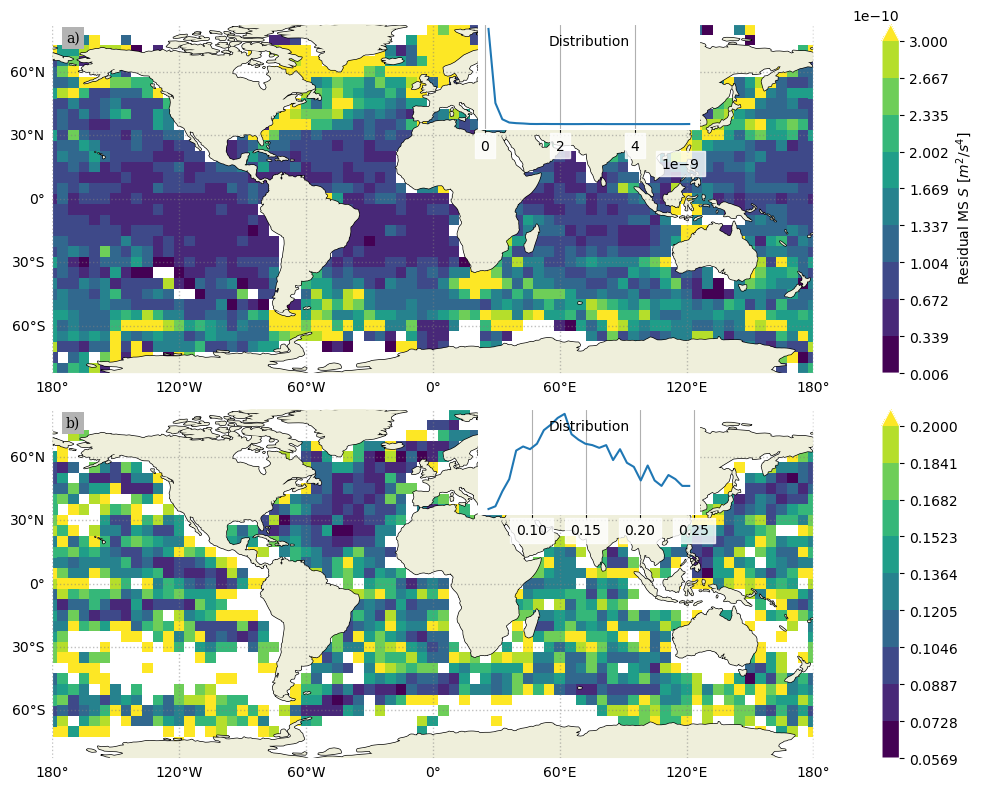

In [19]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.geodesic as cgeo

import matplotlib.transforms as mtransforms
crs = ccrs.PlateCarree()



fig, axs = plt.subplots(2,1,
                        subplot_kw={'projection': ccrs.PlateCarree()},
                        figsize=(14,8), frameon=False)
ax = axs[0]
dsm['S'].attrs = {'long_name':r'Residual MS $S$ $[m^2/s^4]$'}
ins = plot_lonlat(dsm['S'],ax, 'a', vmax = 3e-10, levels=10, retins=True)
#dsm['sum_'+id_co].plot.contour(ax=ax, levels=[2e-10], colors=['red'], transform=ccrs.PlateCarree())
#ins.axvline(2e-10, color = 'r')
#dsm['sum_'+id_co].plot.contour(ax=ax, levels=[7e-11], colors=['orange'], transform=ccrs.PlateCarree())
#ins.axvline(7e-11, color = 'orange')
ax = axs[1]
ins = plot_lonlat(Se_, ax, 'b', vmax = 0.2, levels=10, retins=True)

for ax in axs :
    ax.coastlines()
    ax.add_feature(cfeature.LAND, zorder=5)
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle=':', zorder=5)
    gl.xlabels_top = False
    gl.ylabels_right = False
#fig.suptitle('Along-track')
fig.tight_layout(rect=[0,0,1,1])
#fig.savefig('../images_all/lonlat_msre_nmsre_alg.png', bbox_inches='tight',   dpi=300)

In [5]:
cluster.close()